# LoC Data Package Tutorial: City and Telephone Directories

This notebook will demonstrate basic usage of using Python for interacting with [data packages from the Library of Congress](https://data.labs.loc.gov/packages/) via the [Directory Holdings Data Package](https://data.labs.loc.gov/directories/) which is derived from the Library's [United States: City and Telephone Directories](https://guides.loc.gov/united-states-city-telephone-directories/introduction) and [Directories By Address: Inventories of Library Collections Library Guides](https://guides.loc.gov/address-directories/criss-cross). We will:

1. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
2. [Visualize the data](#Visualize-the-data)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Query the metadata in a data package

First we will download a data package's metadata file, print a summary of the items' location values, then filter by a particular location.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's City Directories `metadata.json` file:

In [1]:
import io

import pandas as pd                     # for reading, manipulating, and displaying data
import requests

DATA_URL = 'https://data.labs.loc.gov/directories/'

metadata_url = f'{DATA_URL}by-directory-type/City Directories/metadata.json'
# Also try: by-directory-type/Criss-cross Directories/metadata.json 
# Or: by-directory-type/Telephone Directories/metadata.json 
response = requests.get(metadata_url, timeout=60)
data = response.json()
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 56,612 entries.


Next let's convert to pandas DataFrame and print the available properties

In [2]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

State_region, Locality, Date, Source_collection, Location_text, Date_text, Genre, Original_format, Language, Notes, Repository, Type_of_resource, Digitized, Url, Shelf_id, Directory_type, Location


Next print the top 10 most frequent locations in this dataset

In [3]:
# Since "State_region" are a list, we must "explode" it so there's just one state/region per row
# We convert to DataFrame so it displays as a table
df['State_region'].explode().value_counts().iloc[:10].to_frame()

,State_region
Massachusetts,5775
New York,4334
Pennsylvania,3364
Ohio,2853
New Jersey,2763
California,2567
Michigan,2514
Illinois,2416
Connecticut,2188
Indiana,1990


Now we filter the results to only those items with State "Ohio"

In [4]:
df_by_location = df.explode('State_region')
subset = df_by_location[df_by_location.State_region == 'Ohio']
print(f'Found {subset.shape[0]:,} items with state "Ohio"')

Found 2,853 items with state "Ohio"


## Visualize the data

Finally we will visualize the location data on a map.

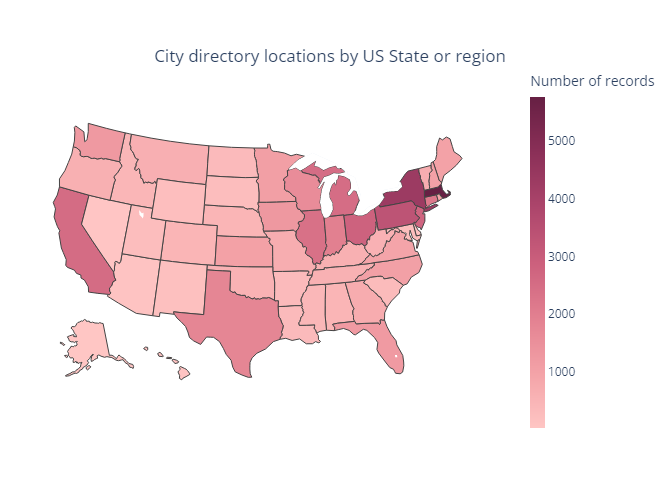

In [5]:
from collections import Counter
from IPython.display import Image
import plotly.express as px         # For displaying charts and graphs

us_state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO",
    "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
    "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
    "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC", "American Samoa": "AS",
    "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR", "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI"
}

locations = df_by_location['State_region'] # Get a list of all the states/regions
locations_abbrev = [us_state_to_abbrev[loc] for loc in locations if loc in us_state_to_abbrev.keys()] # Convert to abbreviations
counter = Counter(locations_abbrev) # Count them
location_list = list(counter.keys())
counts = list(counter.values())

# Visualize it on a map
fig = px.choropleth(locations=location_list, locationmode="USA-states", color=counts, scope="usa",
                        color_continuous_scale=px.colors.sequential.Burg, labels={'color': 'Number of records'})
fig.update_layout(
        title=dict(text=f'City directory locations by US State or region', yanchor='top', xanchor='center', y=.9, x=.5),
        margin=dict(l=0, r=0, t=0, b=0, pad=0),
        coloraxis=dict(colorbar=dict(thickness=15, len=.75, xpad=5)),
        width=660
    )
Image(fig.to_image(format="png"))


